### Sensor Constants

In [1]:
sensor_name = 'alpha_co_conc'
sampling_period = 15 * 60

## Upload Data from File

In [2]:
import pandas as pd

directory_path = 'input/'
file_name = sensor_name + 'dataframe_no_changepoint_1hr.csv'
df = pd.read_csv(directory_path + file_name)
df.head()

DateTime  measuring     value
0  2022-11-27 14:30:00   113.0900  0.129557
1  2022-11-27 17:30:00    96.1275  0.110125
2  2022-11-27 18:30:00    91.3725  0.104677
3  2022-11-27 19:30:00    88.2100  0.101054
4  2022-11-27 20:30:00    87.8575  0.100650

### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [3]:
# Remove the first column with the indexes and save data into web dataframe
dataframe = df.drop(df.columns[0], axis='columns')
dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_80458/580442286.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


measuring     value
DateTime                                
2022-11-27 14:30:00   113.0900  0.129557
2022-11-27 17:30:00    96.1275  0.110125
2022-11-27 18:30:00    91.3725  0.104677
2022-11-27 19:30:00    88.2100  0.101054
2022-11-27 20:30:00    87.8575  0.100650

### Plot raw data

<Axes: xlabel='DateTime'>

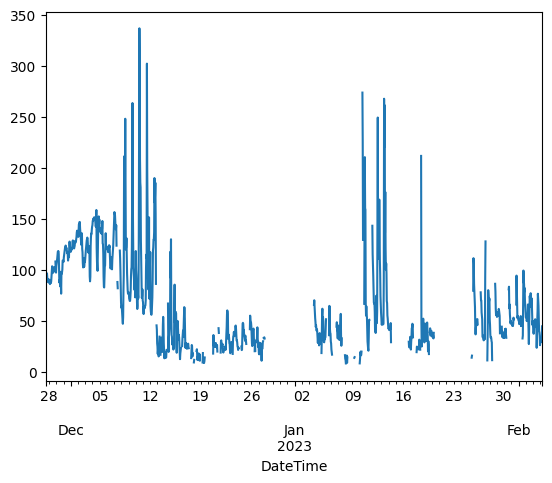

In [4]:
sensor_dataframe['measuring'].resample('1H').mean().plot()

## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

(array([130., 266., 177.,  95.,  65.,  71.,  98.,  70.,  41.,   9.,   7.,
          4.,   5.,   1.,   3.,   3.,   1.,   2.,   0.,   1.]),
 array([  7.24333333,  23.70729167,  40.17125   ,  56.63520833,
         73.09916667,  89.563125  , 106.02708333, 122.49104167,
        138.955     , 155.41895833, 171.88291667, 188.346875  ,
        204.81083333, 221.27479167, 237.73875   , 254.20270833,
        270.66666667, 287.130625  , 303.59458333, 320.05854167,
        336.5225    ]),
 <BarContainer object of 20 artists>)

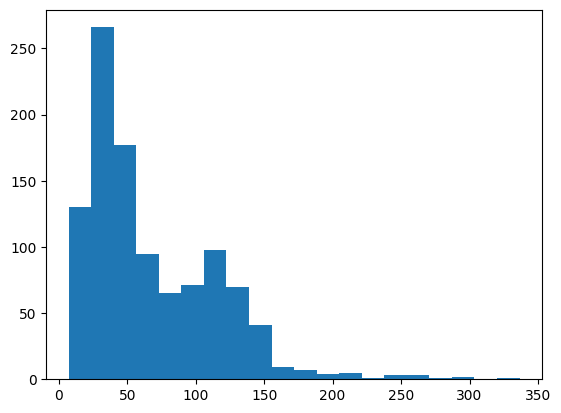

In [5]:
import matplotlib.pyplot as plt

plt.hist(sensor_dataframe['measuring'], bins=20)

## Decompose signal

In [8]:
sensor_dataframe['measuring'].resample('1H').median()

DateTime
2022-11-27 14:00:00    113.09000
2022-11-27 15:00:00          NaN
2022-11-27 16:00:00          NaN
2022-11-27 17:00:00     96.12750
2022-11-27 18:00:00     91.37250
                         ...    
2023-02-04 02:00:00     30.30625
2023-02-04 03:00:00     30.43125
2023-02-04 04:00:00     28.93625
2023-02-04 05:00:00     33.25375
2023-02-04 06:00:00     44.49625
Freq: H, Name: measuring, Length: 1649, dtype: float64

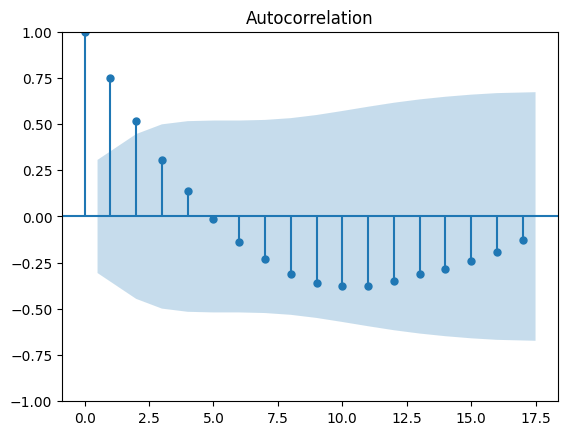

<Figure size 910x700 with 0 Axes>

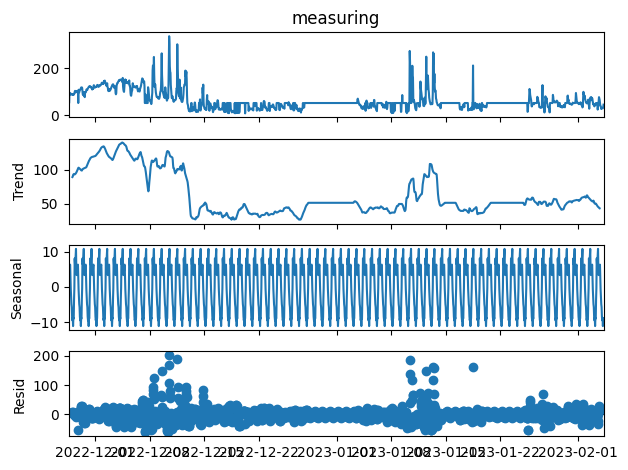

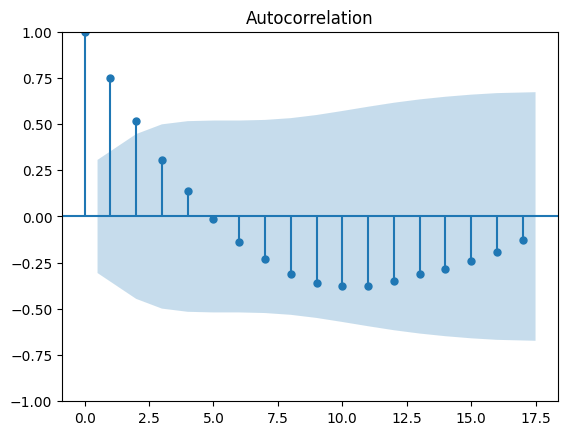

In [17]:
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

fill_value = sensor_dataframe['measuring'].median()
signal = seasonal_decompose(sensor_dataframe['measuring'].resample('1H').median().fillna(value=fill_value),
                                      model='additive', period=24)
plt.figure(figsize=(1.3*7,7))
signal.plot()
tsaplots.plot_acf(stattools.acf(signal.resid.dropna(), nlags=40, fft=False))

In [29]:
import scipy.stats as stats

# Extract residuals from the decomposition
residuals = signal.resid.dropna()

# Optionally, you can apply a normality test
_, p_value = stats.shapiro(residuals)

# Check the p-value
if p_value > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals may not be normally distributed, p_value is ", p_value)


Residuals may not be normally distributed, p_value is  1.8034711235860396e-42


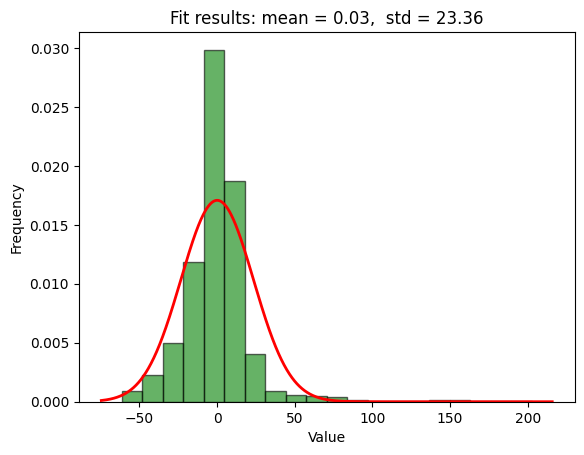

In [27]:
from scipy.stats import norm
import numpy as np

# Plot the histogram
plt.hist(signal.resid, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot the theoretical normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, signal.resid.size)
p = norm.pdf(x, np.mean(signal.resid), np.std(signal.resid))
plt.plot(x, p, 'r', linewidth=2)

# Customize the plot
title = "Fit results: mean = %.2f,  std = %.2f" % (np.mean(signal.resid), np.std(signal.resid))
plt.title(title)
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()


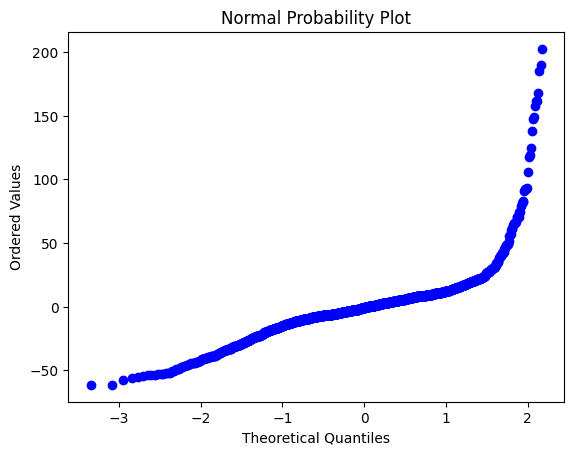

In [21]:
from scipy import stats

# Create a normal probability plot
probplot = stats.probplot(signal.resid, plot=plt)

# Customize the plot (optional)
plt.title('Normal Probability Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

# Display the plot
plt.show()


### Kalman filter

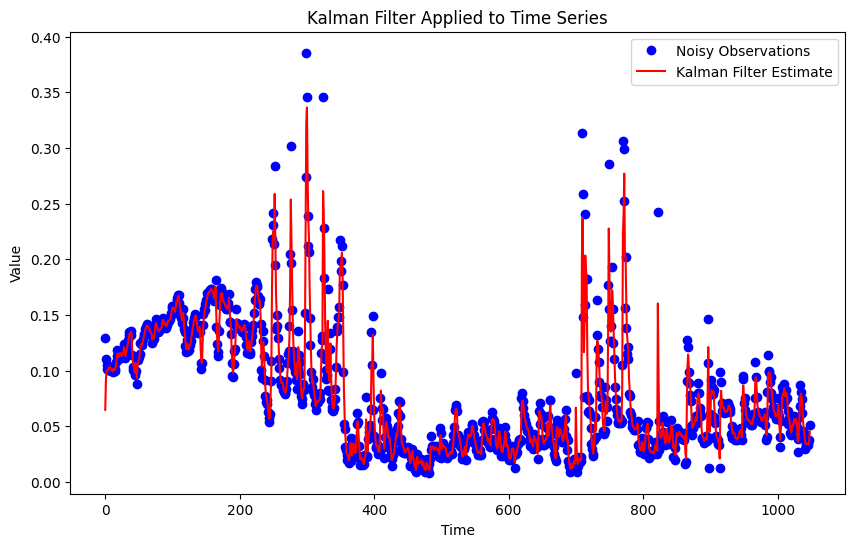

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Simulate noisy observations
observations = sensor_dataframe['value'].to_numpy()

# Apply Kalman filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate state and covariance matrices
state_means, state_covariances = kf.filter(observations)

# Plot the original data, true values, and the Kalman filter estimate
plt.figure(figsize=(10, 6))
plt.plot(observations, label='Noisy Observations', marker='o', linestyle='None', color='blue')
plt.plot(state_means, label='Kalman Filter Estimate', linestyle='-', color='red')

plt.title('Kalman Filter Applied to Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Axes: xlabel='DateTime'>

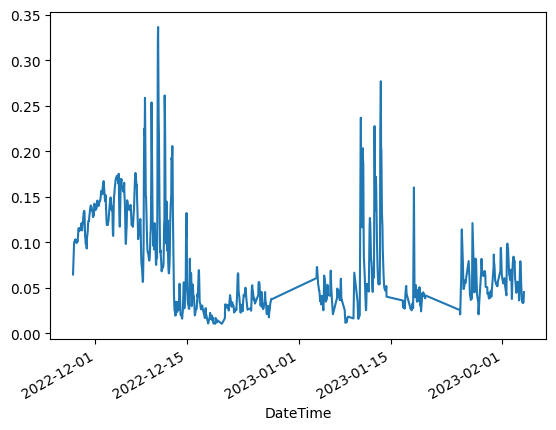

In [46]:
filter_series = pd.Series(state_means.flatten())
filter_series.index = sensor_dataframe.index
sensor_dataframe['filtered'] = filter_series
filter_series.plot()

## Compare with original data

In [47]:
input_data_directory = 'input/'
reference_data_path = input_data_directory + 'ref_air_quality_data_Vila_Moema.csv'
reference_column_name = 'Monóxido de Carbono'

## Load reference and sensor data

In [48]:
import pandas as pd

reference_data = pd.read_csv(reference_data_path)
reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))
reference_data = reference_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
reference_data.index = reference_data['DateTime']
reference_data = reference_data.drop(columns='DateTime')[reference_column_name]

sensor_data = sensor_dataframe
reference_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_80458/1347629147.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))


DateTime
2022-01-01 02:30:00    0.1467
2022-01-01 03:30:00    0.1544
2022-01-01 04:30:00    0.1167
2022-01-01 05:30:00    0.1079
2022-01-01 06:30:00    0.1154
Name: Monóxido de Carbono, dtype: float64

### Select period of interest according to CO sensor data

In [49]:
reference_data = reference_data[reference_data.index >= sensor_data.index[0]]
reference_data = reference_data[reference_data.index <= sensor_data.index[-1]]
reference_data

DateTime
2022-11-27 14:30:00    0.0013
2022-11-27 15:30:00    0.0050
2022-11-27 16:30:00    0.0121
2022-11-27 17:30:00    0.0011
2022-11-27 18:30:00    0.0095
                        ...  
2023-02-04 02:30:00    0.1279
2023-02-04 03:30:00    0.1174
2023-02-04 04:30:00    0.1153
2023-02-04 05:30:00    0.1395
2023-02-04 06:30:00    0.1864
Name: Monóxido de Carbono, Length: 1649, dtype: float64

## Append reference column to CO sensor Data

In [50]:
sensor_data['reference'] = reference_data
sensor_data

measuring     value  filtered  reference
DateTime                                                     
2022-11-27 14:30:00  113.09000  0.129557  0.064778     0.0013
2022-11-27 17:30:00   96.12750  0.110125  0.091986     0.0011
2022-11-27 18:30:00   91.37250  0.104677  0.099796     0.0095
2022-11-27 19:30:00   88.21000  0.101054  0.100573     0.0178
2022-11-27 20:30:00   87.85750  0.100650  0.100621     0.0133
...                        ...       ...       ...        ...
2023-02-04 02:30:00   30.30625  0.034719  0.034357     0.1279
2023-02-04 03:30:00   30.43125  0.034862  0.034669     0.1174
2023-02-04 04:30:00   28.93625  0.033150  0.033730     0.1153
2023-02-04 05:30:00   33.25375  0.038096  0.036428     0.1395
2023-02-04 06:30:00   44.49625  0.050975  0.045419     0.1864

[1049 rows x 4 columns]

### Separate between high and low concentrations

In [383]:
sensor_data['Concentration tag'] = sensor_data['reference'].apply(lambda value: 'LOW' if value < 0.15 else 'HIGH')
sensor_data

measuring     value  filtered  reference  \
DateTime                                                        
2022-11-27 14:30:00  113.09000  0.129557  0.064778     0.0013   
2022-11-27 17:30:00   96.12750  0.110125  0.091986     0.0011   
2022-11-27 18:30:00   91.37250  0.104677  0.099796     0.0095   
2022-11-27 19:30:00   88.21000  0.101054  0.100573     0.0178   
2022-11-27 20:30:00   87.85750  0.100650  0.100621     0.0133   
...                        ...       ...       ...        ...   
2023-02-04 02:30:00   30.30625  0.034719  0.034357     0.1279   
2023-02-04 03:30:00   30.43125  0.034862  0.034669     0.1174   
2023-02-04 04:30:00   28.93625  0.033150  0.033730     0.1153   
2023-02-04 05:30:00   33.25375  0.038096  0.036428     0.1395   
2023-02-04 06:30:00   44.49625  0.050975  0.045419     0.1864   

                    Concentration tag  
DateTime                               
2022-11-27 14:30:00               LOW  
2022-11-27 17:30:00               LOW  
2022-11-27 18:30:00               LOW  
2022-11-27 19:30:00               LOW  
2022-11-27 20:30:00               LOW  
...                               ...  
2023-02-04 02:30:00               LOW  
2023-02-04 03:30:00               LOW  
2023-02-04 04:30:00               LOW  
2023-02-04 05:30:00               LOW  
2023-02-04 06:30:00              HIGH  

[1049 rows x 5 columns]

### Plot reference and sensor data

<Axes: xlabel='DateTime'>

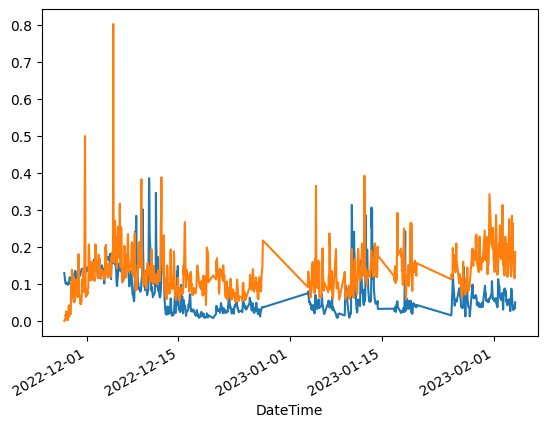

In [51]:
sensor_data['value'].plot()
sensor_data['reference'].plot()

<Axes: xlabel='DateTime'>

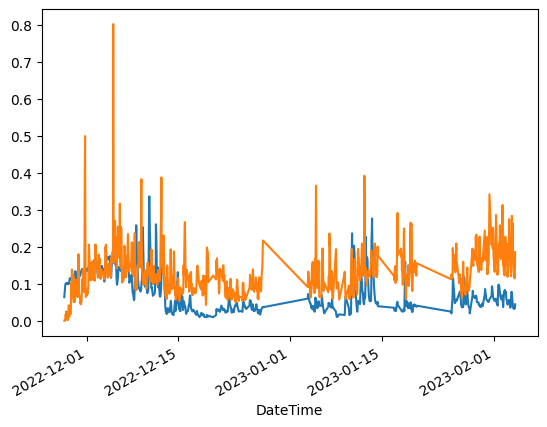

In [54]:
sensor_data['filtered'].plot()
sensor_data['reference'].plot()

## Plot sensor vs. reference

Spearmans correlation coefficient: 0.301
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.301
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, "Kendall's tau=0.201, p<0.05")

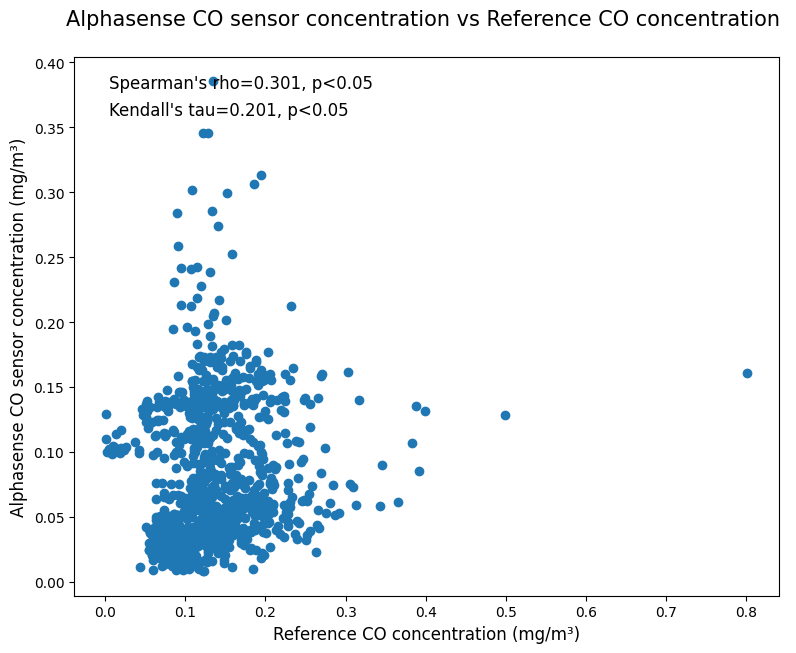

In [55]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))

plt.scatter(sensor_data['reference'], sensor_data['value'])
plt.title('Alphasense CO sensor concentration vs Reference CO concentration \n', 
          fontdict={'fontsize':15})
plt.xlabel('Reference CO concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
plt.ylabel('Alphasense CO sensor concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(sensor_data['reference'], sensor_data['value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(sensor_data['reference'], sensor_data['value'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

## Calibrate data

### Prepare training and test sets

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

reference_median = sensor_data['reference'].median()
sensor_median = sensor_data['filtered'].median()
reference_max = sensor_data['reference'].max()
sensor_max = sensor_data['filtered'].max()
reference_mean = sensor_data['reference'].mean()
sensor_mean = sensor_data['filtered'].mean()
reference_std = sensor_data['reference'].std()
sensor_std = sensor_data['filtered'].std()

y = sensor_data['reference'].fillna(value=reference_median).values.reshape(-1,1) # / reference_mean * reference_std
X = sensor_data['filtered'].fillna(value=sensor_median).values.reshape(-1,1) # / sensor_mean * sensor_std

low_concentration_data = sensor_data[sensor_data['Concentration tag'] == 'LOW']
reference_median = low_concentration_data['reference'].median()
sensor_median = low_concentration_data['filtered'].median()

y_low = low_concentration_data['reference'].fillna(value=reference_median).values.reshape(-1,1)
X_low = low_concentration_data['filtered'].fillna(value=sensor_median).values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, random_state=42)

### Multi-layer Perceptron regressor all data

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

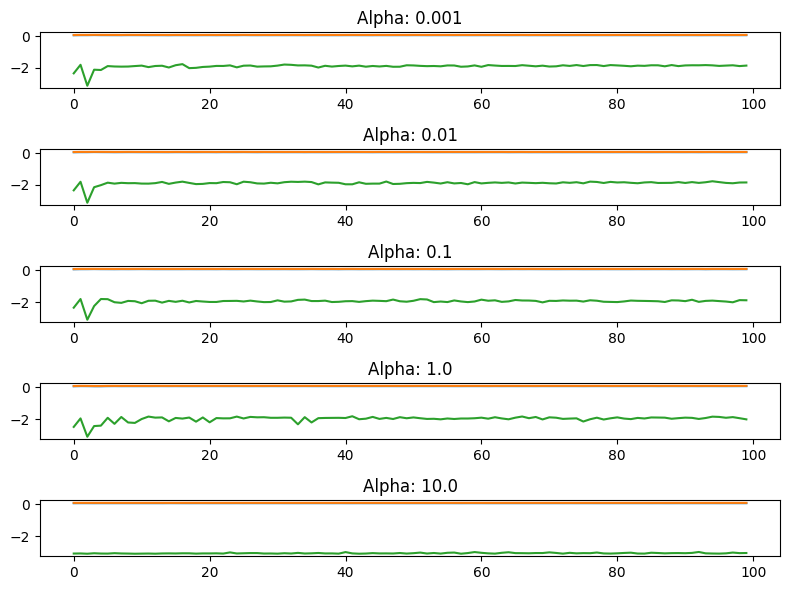

In [364]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error

w, h = 4, 3
margin = 0.5
alphas = np.logspace(-3, 1, 5)
total_elements_layer = range(100)

fig, axs = plt.subplots(len(alphas), 1, figsize=(8, 6))

names = []
i = 1
for alpha in alphas:
    mae_list = []
    rmse_list = []
    r2_list = []
    names.append(f"alpha {alpha:.2f}")
    regr = []
    for elements_first_layer in total_elements_layer:
        mlp = make_pipeline(
            StandardScaler(),
            MLPRegressor(
                solver="lbfgs", 
                alpha=alpha, 
                hidden_layer_sizes=(elements_first_layer + 1,), 
                random_state=42, 
                max_iter=1000, 
                early_stopping=True
            )
        )
        regr = mlp.fit(X_train, y_train)
        # Evaluate the model
        cross_validation = cross_validate(mlp, X, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        r2 = cross_validation['test_r2'].min()
        rmse = abs(cross_validation['test_neg_root_mean_squared_error']).max()
        mae = abs(cross_validation['test_neg_mean_absolute_error']).max()

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

    ax = axs[i - 1]
    i = i + 1
    ax.plot(mae_list)
    ax.plot(rmse_list)
    ax.plot(r2_list)
    ax.set_title(f'Alpha: {alpha}')

plt.tight_layout()
plt.show()

Root Mean Squared Error: -0.05994966312740585 +/- 0.01834523649798856
Mean Absolute Error: -0.04539421014995548 +/- 0.01629305608059596
R2: -0.550789026624438 +/- 0.7330800279495211


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

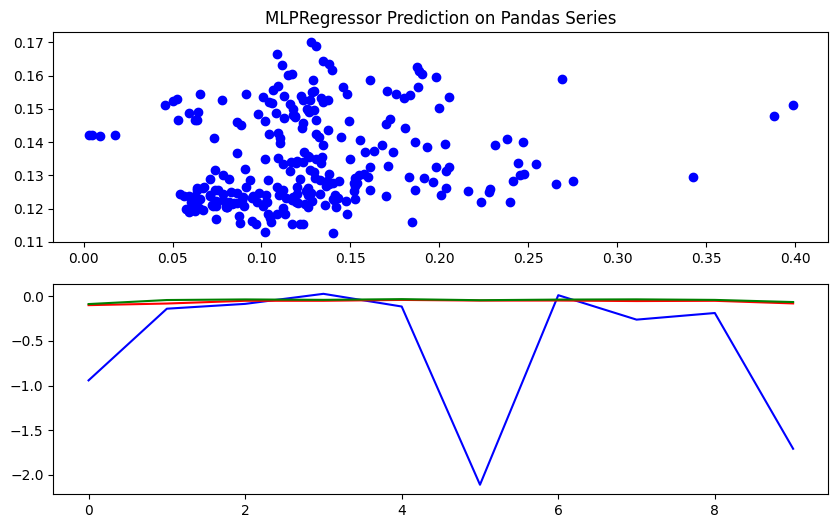

In [375]:
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(solver="lbfgs", hidden_layer_sizes=(4,), random_state=42, max_iter=1000)
)
cross_validation = cross_validate(mlp, X, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
regr = mlp.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# Evaluate the model
r2 = cross_validation['test_r2']
rmse = cross_validation['test_neg_root_mean_squared_error']
mae = cross_validation['test_neg_mean_absolute_error']

print(f'Root Mean Squared Error: {rmse.mean()} +/- {rmse.std()}')
print(f'Mean Absolute Error: {mae.mean()} +/- {mae.std()}')
print(f'R2: {r2.mean()} +/- {r2.std()}')

# Plot the results
plt.figure(figsize=(10, 6))
ax = plt.subplot(2,1,1)
ax.scatter(y_test, y_pred, color='blue', label='MLPRegressor Prediction')
plt.title('MLPRegressor Prediction on Pandas Series')

ax = plt.subplot(2,1,2)
ax.plot(r2, color='blue')
ax.plot(rmse, color='red')
ax.plot(mae, color='green')

plt.show()

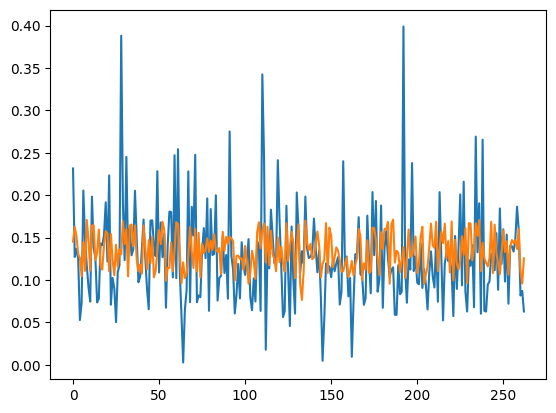

In [373]:
plt.plot(y_test)
plt.plot(y_pred)

(array([ 5., 29., 86., 78., 37., 11., 13.,  1.,  1.,  2.]),
 array([-0.13558442, -0.09659696, -0.05760949, -0.01862203,  0.02036543,
         0.05935289,  0.09834035,  0.13732782,  0.17631528,  0.21530274,
         0.2542902 ]),
 <BarContainer object of 10 artists>)

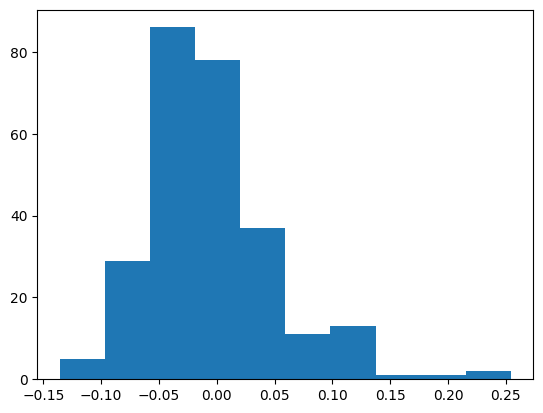

In [344]:
residuals = y_test - y_pred
plt.hist(residuals)

### Multi-layer Perceptron regressor low concentrations

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

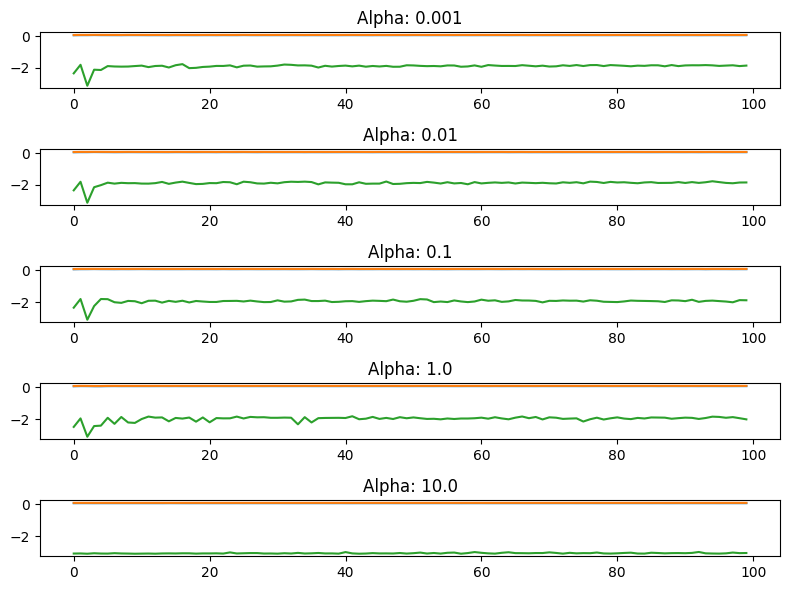

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error

w, h = 4, 3
margin = 0.5
alphas = np.logspace(-3, 1, 5)
total_elements_layer = range(100)

fig, axs = plt.subplots(len(alphas), 1, figsize=(8, 6))

names = []
i = 1
for alpha in alphas:
    mae_list = []
    rmse_list = []
    r2_list = []
    names.append(f"alpha {alpha:.2f}")
    regr = []
    for elements_first_layer in total_elements_layer:
        mlp = make_pipeline(
            StandardScaler(),
            MLPRegressor(
                solver="lbfgs", 
                alpha=alpha, 
                hidden_layer_sizes=(elements_first_layer + 1,), 
                random_state=42, 
                max_iter=1000, 
                early_stopping=True
            )
        )
        regr = mlp.fit(X_train, y_train)
        # Evaluate the model
        cross_validation = cross_validate(mlp, X, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        r2 = cross_validation['test_r2'].min()
        rmse = abs(cross_validation['test_neg_root_mean_squared_error']).max()
        mae = abs(cross_validation['test_neg_mean_absolute_error']).max()

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

    ax = axs[i - 1]
    i = i + 1
    ax.plot(mae_list)
    ax.plot(rmse_list)
    ax.plot(r2_list)
    ax.set_title(f'Alpha: {alpha}')

plt.tight_layout()
plt.show()

Root Mean Squared Error: -0.05994966312740585 +/- 0.01834523649798856
Mean Absolute Error: -0.04539421014995548 +/- 0.01629305608059596
R2: -0.550789026624438 +/- 0.7330800279495211


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

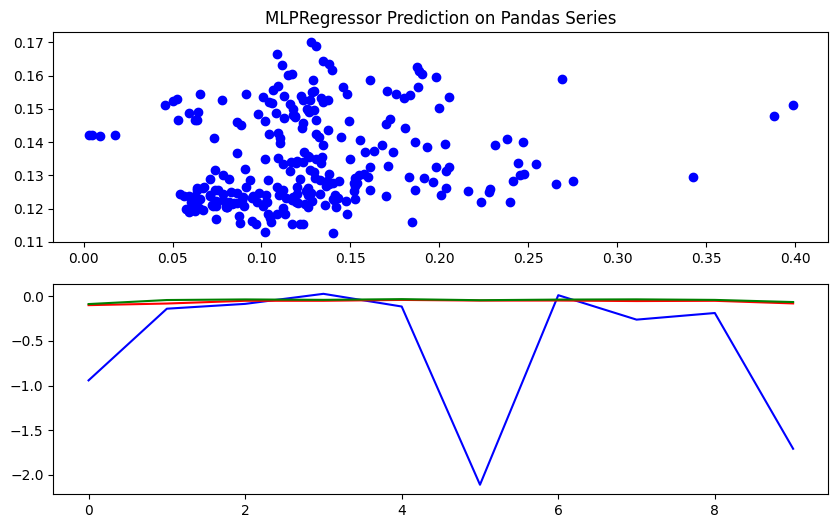

In [ ]:
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(solver="lbfgs", hidden_layer_sizes=(4,), random_state=42, max_iter=1000)
)
cross_validation = cross_validate(mlp, X, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
regr = mlp.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# Evaluate the model
r2 = cross_validation['test_r2']
rmse = cross_validation['test_neg_root_mean_squared_error']
mae = cross_validation['test_neg_mean_absolute_error']

print(f'Root Mean Squared Error: {rmse.mean()} +/- {rmse.std()}')
print(f'Mean Absolute Error: {mae.mean()} +/- {mae.std()}')
print(f'R2: {r2.mean()} +/- {r2.std()}')

# Plot the results
plt.figure(figsize=(10, 6))
ax = plt.subplot(2,1,1)
ax.scatter(y_test, y_pred, color='blue', label='MLPRegressor Prediction')
plt.title('MLPRegressor Prediction on Pandas Series')

ax = plt.subplot(2,1,2)
ax.plot(r2, color='blue')
ax.plot(rmse, color='red')
ax.plot(mae, color='green')

plt.show()

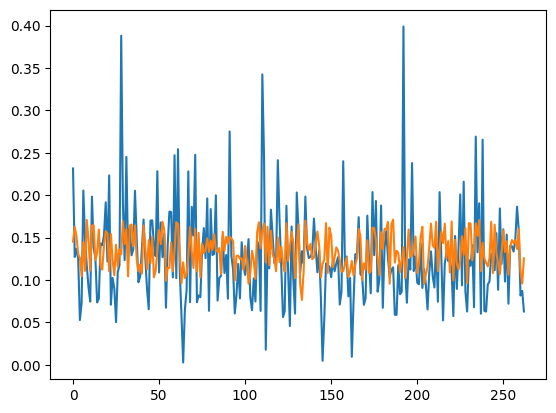

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)

(array([ 5., 29., 86., 78., 37., 11., 13.,  1.,  1.,  2.]),
 array([-0.13558442, -0.09659696, -0.05760949, -0.01862203,  0.02036543,
         0.05935289,  0.09834035,  0.13732782,  0.17631528,  0.21530274,
         0.2542902 ]),
 <BarContainer object of 10 artists>)

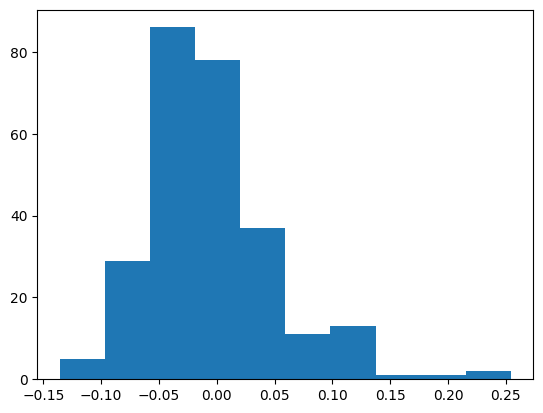

In [ ]:
residuals = y_test - y_pred
plt.hist(residuals)

### Multilinear Regression

Mean Squared Error: 2.7755575615628914e-17
Mean Absolute Error: 2.5660815191807864e-17
R2: 0.01412811844866979


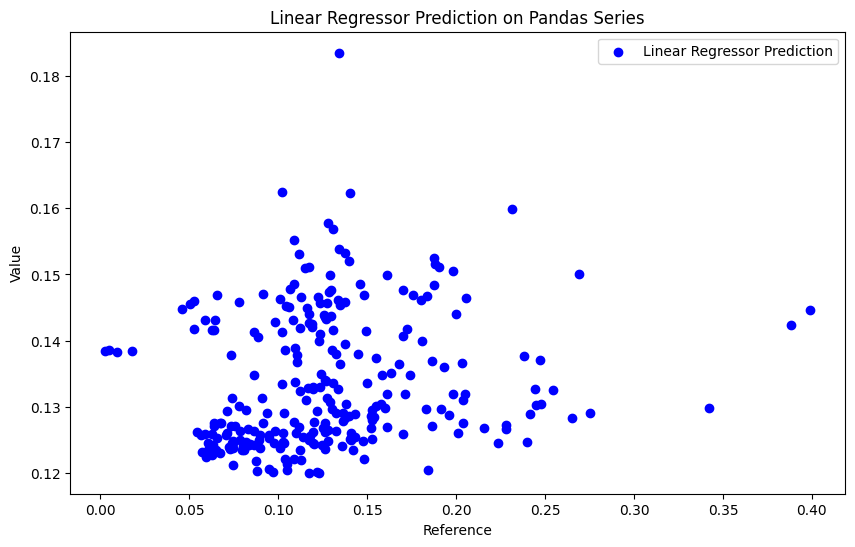

In [350]:
from sklearn.linear_model import LinearRegression

linear = make_pipeline(
    LinearRegression()
)
regr = linear.fit(X_train, y_train)
y_pred = regr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Evaluate the model
mae, rmse = evaluate(regr, X_test, y_pred)

print(f'Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2: {r2}')

# Plot the results
plt.figure(figsize=(10, 6))
# plt.scatter(X_test, y_test, color='black', label='True Values')
plt.scatter(y_test, y_pred, color='blue', label='Linear Regressor Prediction')
plt.title('Linear Regressor Prediction on Pandas Series')
plt.xlabel('Reference')
plt.ylabel('Value')
plt.legend()
plt.show()

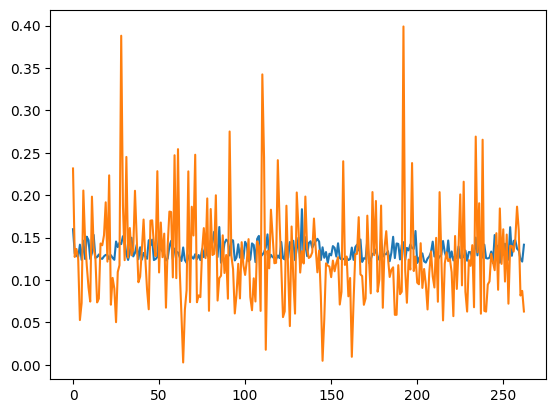

In [351]:
plt.plot(y_pred)
plt.plot(y_test)

(array([ 5., 29., 86., 78., 37., 11., 13.,  1.,  1.,  2.]),
 array([-0.13558442, -0.09659696, -0.05760949, -0.01862203,  0.02036543,
         0.05935289,  0.09834035,  0.13732782,  0.17631528,  0.21530274,
         0.2542902 ]),
 <BarContainer object of 10 artists>)

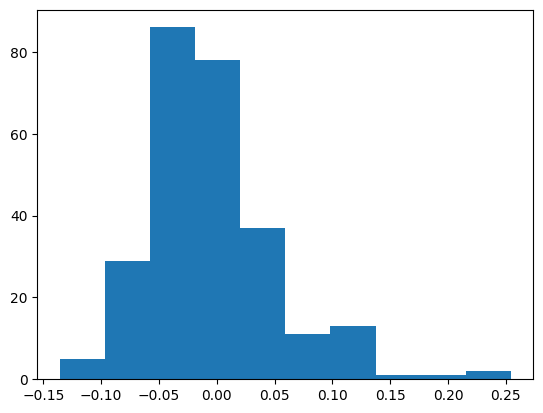

In [347]:
residuals = y_test - y_pred
plt.hist(residuals)

### Decision Tree

Mean Squared Error: 0.004923403490471285


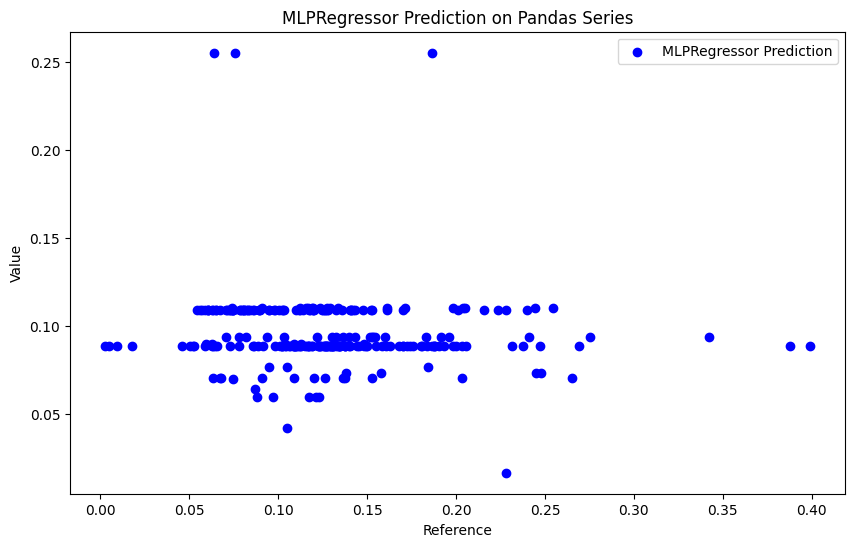

In [360]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train / reference_mean * reference_std, 
                                                               y_train / sensor_mean * sensor_std)

y_pred = regr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(10, 6))
# plt.scatter(X_test, y_test, color='black', label='True Values')
plt.scatter(y_test, y_pred, color='blue', label='MLPRegressor Prediction')
plt.title('MLPRegressor Prediction on Pandas Series')
plt.xlabel('Reference')
plt.ylabel('Value')
plt.legend()
plt.show()

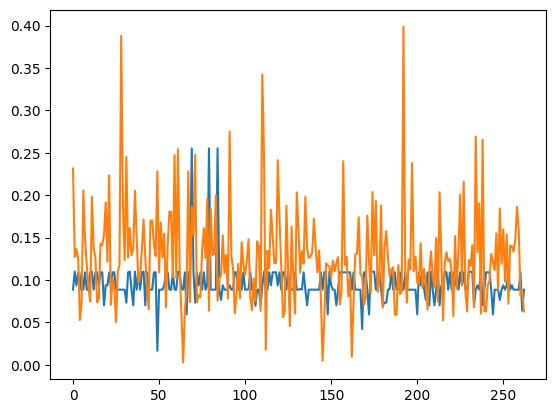

In [362]:
plt.plot(y_pred)
plt.plot(y_test)

### Random Forests

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.0028685331487483348


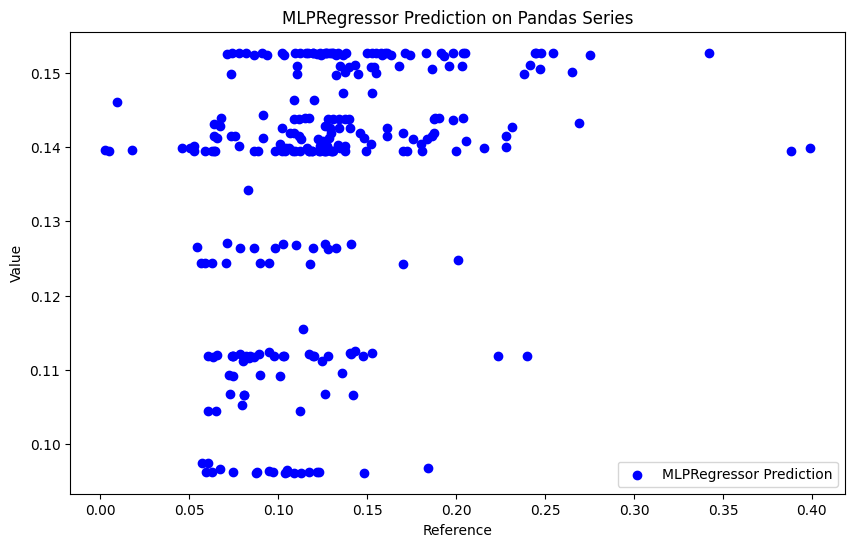

In [356]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=500,max_depth=2, random_state=40).fit(X_train, y_train)
y_pred = regr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(10, 6))
# plt.scatter(X_test, y_test, color='black', label='True Values')
plt.scatter(y_test, y_pred, color='blue', label='MLPRegressor Prediction')
plt.title('MLPRegressor Prediction on Pandas Series')
plt.xlabel('Reference')
plt.ylabel('Value')
plt.legend()
plt.show()

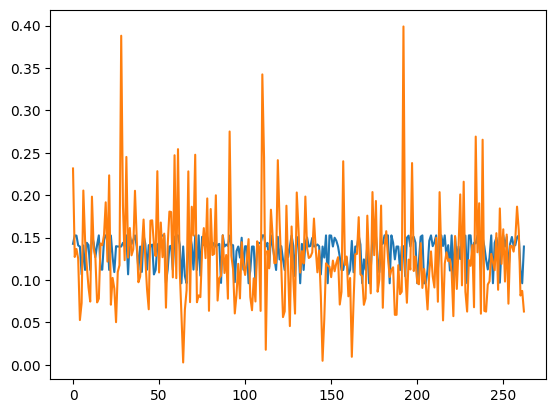

In [357]:
plt.plot(y_pred)
plt.plot(y_test)

### K-Nearest Neighbours

Root Mean Squared Error: -0.06265175680224355 +/- 0.016039632640922757
Mean Absolute Error: -0.04680665430922214 +/- 0.012170414179361095
R2: -0.6757973920463745 +/- 0.6413089178548277


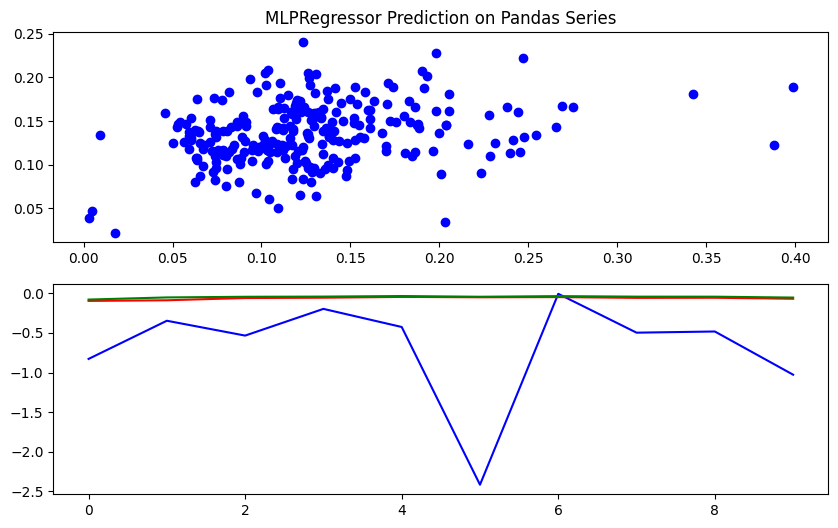

In [382]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=10, weights='distance')
)
cross_validation = cross_validate(pipeline, X, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
regr = pipeline.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# Evaluate the model
r2 = cross_validation['test_r2']
rmse = cross_validation['test_neg_root_mean_squared_error']
mae = cross_validation['test_neg_mean_absolute_error']

print(f'Root Mean Squared Error: {rmse.mean()} +/- {rmse.std()}')
print(f'Mean Absolute Error: {mae.mean()} +/- {mae.std()}')
print(f'R2: {r2.mean()} +/- {r2.std()}')

# Plot the results
plt.figure(figsize=(10, 6))
ax = plt.subplot(2,1,1)
ax.scatter(y_test, y_pred, color='blue', label='MLPRegressor Prediction')
plt.title('MLPRegressor Prediction on Pandas Series')

ax = plt.subplot(2,1,2)
ax.plot(r2, color='blue')
ax.plot(rmse, color='red')
ax.plot(mae, color='green')

plt.show()

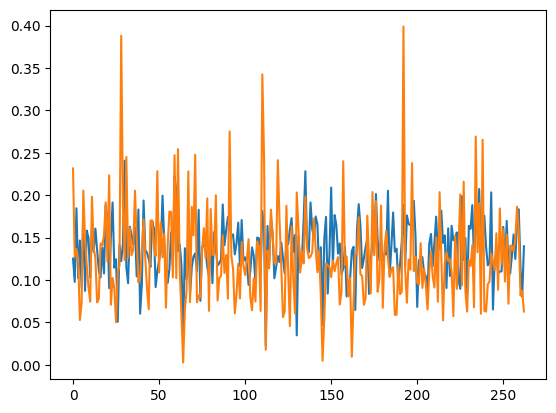

In [379]:
plt.plot(y_pred)
plt.plot(y_test)